In [1]:
# --- Imports & paths ---
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RNG = 42

# Where to save outputs (put everything for defense in one place)
HERE = Path.cwd()  # or Path(__file__).resolve().parent if in .py
OUT = Path("case_studies/overview_ai_ds/outputs")
OUT.mkdir(parents=True, exist_ok=True)
print("Saving outputs to:", OUT.resolve())


Saving outputs to: /home/paunica/projects/DeepNets-Playground/case_studies/overview_ai_ds/scripts/case_studies/overview_ai_ds/outputs


In [2]:
# Load 20 Newsgroups (subset of 4 classes)
CATS = ['rec.autos','rec.motorcycles','sci.med','sci.space']
train = fetch_20newsgroups(subset='train', categories=CATS, remove=('headers','footers','quotes'),
                           shuffle=True, random_state=RNG)
test  = fetch_20newsgroups(subset='test',  categories=CATS, remove=('headers','footers','quotes'),
                           shuffle=True, random_state=RNG)

Xtr, ytr = train.data, train.target
Xte, yte = test.data,  test.target
target_names = train.target_names

print("Train size:", len(Xtr), " Test size:", len(Xte))
print("Classes:", target_names)
print("\nSample text preview:\n", Xtr[0][:400], "...")


Train size: 2379  Test size: 1584
Classes: ['rec.autos', 'rec.motorcycles', 'sci.med', 'sci.space']

Sample text preview:
 Alright, beat this automobile sighting.

Driving along just a hair north of Atlanta, I noticed an old, run down
former car dealership which appeared to deal with, and repair, older
rare or exotic foreign sports cars. I saw:

Ford GT-40 (!), the famous model from Ford, that seemed to win most of 
its races in the late 60s, including Le-Mans 4 or 6 times.

Two Jensen Interceptors, one a convertable, ...


In [3]:
# Pipelines: TF-IDF + classifiers 
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)

logreg = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(max_iter=1000, random_state=RNG))
])

nb = Pipeline([
    ("tfidf", tfidf),
    ("clf", MultinomialNB())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)


In [4]:
# Cross-validation scores 
cv_lr = cross_val_score(logreg, Xtr, ytr, cv=cv, scoring="f1_macro")
cv_nb = cross_val_score(nb,     Xtr, ytr, cv=cv, scoring="f1_macro")

print(f"LogReg CV macro-F1: {cv_lr.mean():.3f} ± {cv_lr.std():.3f}  {np.round(cv_lr,3)}")
print(f"NaiveBayes CV macro-F1: {cv_nb.mean():.3f} ± {cv_nb.std():.3f}  {np.round(cv_nb,3)}")


LogReg CV macro-F1: 0.823 ± 0.017  [0.829 0.795 0.833 0.844 0.814]
NaiveBayes CV macro-F1: 0.836 ± 0.027  [0.834 0.791 0.858 0.87  0.826]


In [5]:
# Fit & test evaluation 
logreg.fit(Xtr, ytr)
yp_lr = logreg.predict(Xte)

nb.fit(Xtr, ytr)
yp_nb = nb.predict(Xte)

print("\nLogReg TEST:")
print(f"acc={accuracy_score(yte, yp_lr):.3f}  f1_macro={f1_score(yte, yp_lr, average='macro'):.3f}")
print(classification_report(yte, yp_lr, target_names=target_names, digits=3))

print("\nNaiveBayes TEST:")
print(f"acc={accuracy_score(yte, yp_nb):.3f}  f1_macro={f1_score(yte, yp_nb, average='macro'):.3f}")
print(classification_report(yte, yp_nb, target_names=target_names, digits=3))



LogReg TEST:
acc=0.819  f1_macro=0.820
                 precision    recall  f1-score   support

      rec.autos      0.793     0.793     0.793       396
rec.motorcycles      0.733     0.847     0.786       398
        sci.med      0.898     0.803     0.848       396
      sci.space      0.877     0.832     0.854       394

       accuracy                          0.819      1584
      macro avg      0.825     0.819     0.820      1584
   weighted avg      0.825     0.819     0.820      1584


NaiveBayes TEST:
acc=0.824  f1_macro=0.824
                 precision    recall  f1-score   support

      rec.autos      0.822     0.806     0.814       396
rec.motorcycles      0.784     0.766     0.775       398
        sci.med      0.814     0.894     0.852       396
      sci.space      0.882     0.832     0.856       394

       accuracy                          0.824      1584
      macro avg      0.825     0.825     0.824      1584
   weighted avg      0.825     0.824     0.824      1584

In [6]:
# Save metrics to JSON (for your overview script to display) 
metrics = {
    "LogReg": {
        "cv_f1_mean": float(cv_lr.mean()), "cv_f1_std": float(cv_lr.std()),
        "test_acc": float(accuracy_score(yte, yp_lr)),
        "test_f1_macro": float(f1_score(yte, yp_lr, average='macro'))
    },
    "NaiveBayes": {
        "cv_f1_mean": float(cv_nb.mean()), "cv_f1_std": float(cv_nb.std()),
        "test_acc": float(accuracy_score(yte, yp_nb)),
        "test_f1_macro": float(f1_score(yte, yp_nb, average='macro'))
    }
}
(OUT / "metrics_20news.json").write_text(json.dumps(metrics, indent=2))
print("Saved →", OUT / "metrics_20news.json")


Saved → case_studies/overview_ai_ds/outputs/metrics_20news.json


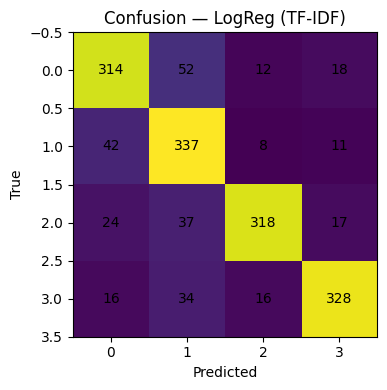

Saved: case_studies/overview_ai_ds/outputs/nlp_confusion_logreg.png


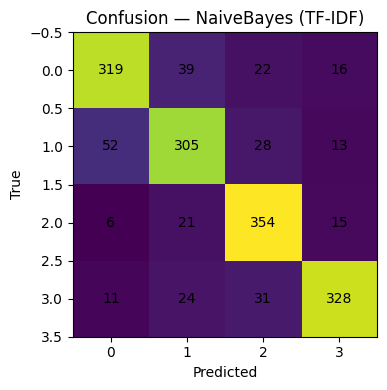

Saved: case_studies/overview_ai_ds/outputs/nlp_confusion_naive_bayes.png


In [7]:
# Confusion matrices + save PNGs 
def save_confusion(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            v = cm[i,j]
            plt.text(j, i, v, ha="center", va="center")
    plt.tight_layout()
    path = OUT / fname
    plt.savefig(path, dpi=150)
    plt.show()
    print("Saved:", path)

save_confusion(yte, yp_lr, "Confusion — LogReg (TF-IDF)", "nlp_confusion_logreg.png")
save_confusion(yte, yp_nb, "Confusion — NaiveBayes (TF-IDF)", "nlp_confusion_naive_bayes.png")


In [8]:
# Most informative features per class for LogReg 
# Works for linear models; for 4 classes we can show top weights per class.
clf = logreg.named_steps["clf"]
vocab = logreg.named_steps["tfidf"].get_feature_names_out()

if hasattr(clf, "coef_"):
    for cls_idx, cls_name in enumerate(target_names):
        coefs = clf.coef_[cls_idx]
        top_pos = np.argsort(coefs)[-10:][::-1]
        top_neg = np.argsort(coefs)[:10]
        print(f"\nClass: {cls_name}")
        print("  Top + tokens:", [vocab[i] for i in top_pos])
        print("  Top - tokens:", [vocab[i] for i in top_neg])



Class: rec.autos
  Top + tokens: ['car', 'cars', 'the car', 'dealer', 'ford', 'engine', 'auto', 'toyota', 'gt', 'price']
  Top - tokens: ['bike', 'of', 'space', 'to', 'is', 'bikes', 'dod', 'some', 'of the', 'the bike']

Class: rec.motorcycles
  Top + tokens: ['bike', 'dod', 'bikes', 'ride', 'motorcycle', 'helmet', 'riding', 'the bike', 'dog', 'bmw']
  Top - tokens: ['space', 'of', 'car', 'is', 'be', 'are', 'would', 'these', 'cars', 'msg']

Class: sci.med
  Top + tokens: ['of', 'msg', 'is', 'doctor', 'disease', 'medical', 'she', 'pain', 'patients', 'food']
  Top - tokens: ['car', 'space', 'bike', 'the', 'cars', 'on', 'engine', 'you', 'dod', 'drive']

Class: sci.space
  Top + tokens: ['space', 'nasa', 'orbit', 'launch', 'moon', 'earth', 'shuttle', 'spacecraft', 'the moon', 'lunar']
  Top - tokens: ['my', 'car', 'your', 'bike', 'cars', 'me', 'with', 'any', 'msg', 'you']
